In [2]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

In [3]:
import numpy as np
import pandas as pd

In [4]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [5]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [6]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [7]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [8]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [9]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [10]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [11]:
#use inspector to get table names (same as base.classes.keys)
inspector = inspect(engine)
inspector.get_table_names()

['measurement', 'station']

In [12]:
#get the column types and one row of data for 'measurment'
columns = inspector.get_columns('measurement')
for column in columns:
    print(column["name"], column["type"])
    
first_rowM = session.query(Measurement).first()
first_rowM.__dict__

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x7ff2b24ff750>,
 'station': 'USC00519397',
 'prcp': 0.08,
 'tobs': 65.0,
 'date': '2010-01-01',
 'id': 1}

In [13]:
#get the column types and one row of data for 'station'
columns = inspector.get_columns('station')
for column in columns:
    print(column["name"], column["type"])
    
first_rowS = session.query(Station).first()
first_rowS.__dict__

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x7ff2b251d610>,
 'station': 'USC00519397',
 'latitude': 21.2716,
 'elevation': 3.0,
 'name': 'WAIKIKI 717.2, HI US',
 'longitude': -157.8168,
 'id': 1}

Last data date: 2017-08-23
One year prior: 2016-08-23


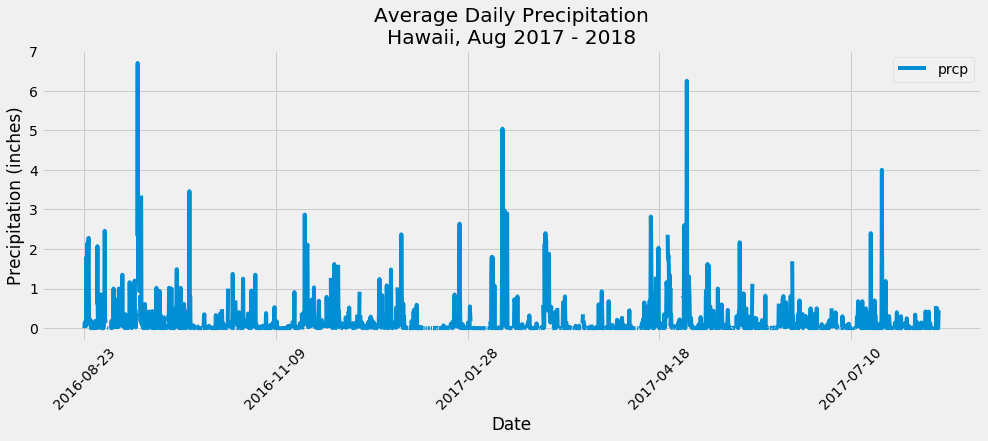

In [45]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
engine.execute("SELECT m.'date', m.'prcp' FROM measurement m WHERE m.'date' >= '2016-08-23'").fetchall()

# Calculate the date 1 year ago from the last data point in the database
for maxDate in (session.query(Measurement.date).order_by(Measurement.date.desc()).first()):
    print(f'Last data date: {maxDate}')
end_date = pd.to_datetime(maxDate).date()
start_date = end_date - pd.DateOffset(years = 1)
start_date = pd.to_datetime(start_date).date()

print(f'One year prior: {start_date}')

# Perform a query to retrieve the data and precipitation scores
sel = [Measurement.date, 
      (Measurement.prcp)]
year_precipitation = session.query(*sel).\
     filter(Measurement.date >= start_date).\
     filter(Measurement.date <= end_date).\
     order_by(Measurement.date.asc()).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
df = pd.DataFrame(year_precipitation, columns=['date', 'prcp'])
df.set_index('date', inplace=True)

# Sort the dataframe by date
sortDF = df.sort_values(by=['date'])

# Use Pandas Plotting with Matplotlib to plot the data
ax = sortDF.plot(rot=45, figsize=(15,5))
ax.set(xlabel="Date",
        ylabel="Precipitation (inches)",
        title="Average Daily Precipitation\nHawaii, Aug 2017 - 2018")
plt.show()

#save graph as png to Images folder
fig = ax.get_figure()
fig.savefig(f'Images/Average Daily Precipitation.png')

In [15]:
#export precipitation data as json for app.py
#sortDF.reset_index(inplace=True)
#sortDF
sortDF.to_json(r'precipitationDF.json',orient="table")
#year_precipitation

In [16]:
# Use Pandas to calcualte the summary statistics for the precipitation data
df.describe()

,prcp
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [17]:
# Design a query to show how many stations are available in this dataset?
#engine.execute("SELECT DISTINCT m.'station' FROM measurement m WHERE m.'date' >= '2016-08-23'").fetchall()
engine.execute("SELECT COUNT(DISTINCT m.'station') FROM measurement m").fetchall()
engine.execute("SELECT COUNT(DISTINCT s.'station') FROM station s").fetchall()

[(9,)]

In [18]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
engine.execute('''
SELECT s.'station', COUNT(m.'id') as measurments
FROM station s, measurement m WHERE m.'station' = s.'station'
GROUP BY s.'station'
ORDER BY measurments desc''').fetchall()

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [49]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
sel = [Measurement.station, 
       func.max(Measurement.tobs), 
       func.min(Measurement.tobs), 
       func.avg(Measurement.tobs)]

topStationStats = session.query(*sel).\
    filter(Measurement.station == 'USC00519281').all()
#topStationStats

#add to dataframe for data headers
topStationStatsDF = pd.DataFrame(topStationStats, columns=['Station', 'MaxTemp', 'MinTemp', 'MeanTemp'])
topStationStatsDF

,Station,MaxTemp,MinTemp,MeanTemp
0,USC00519281,85.0,54.0,71.663781


Last station data date: 2017-08-18


Text(0.5, 1.0, 'Top Station Temperature Histogram')

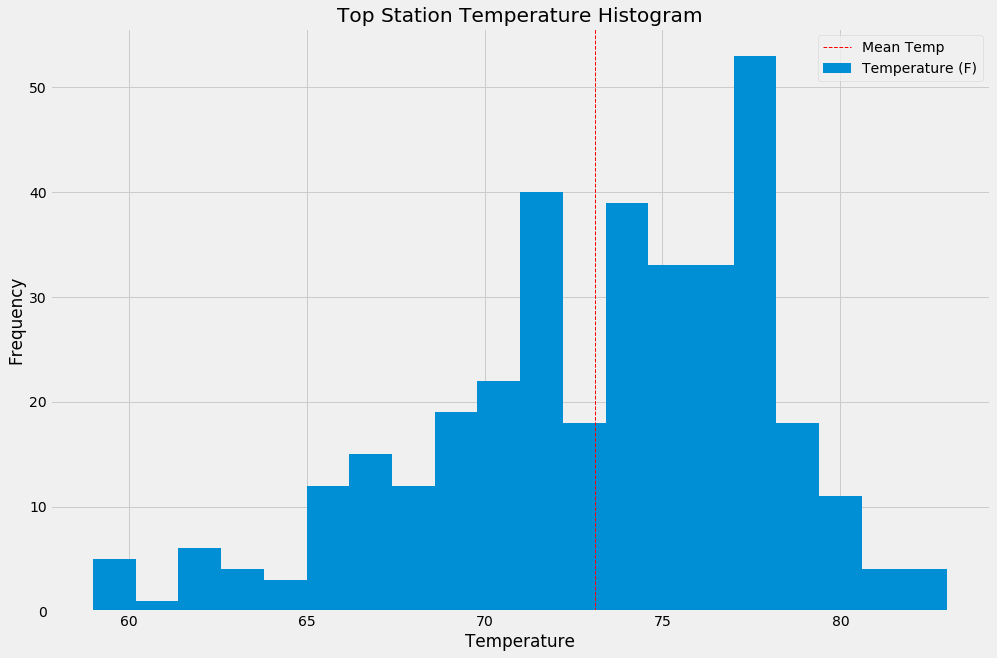

In [53]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
for stationMaxDate in (session.query(Measurement.date).filter(Measurement.station == 'USC00519281').order_by(Measurement.date.desc()).first()):
    print(f'Last station data date: {stationMaxDate}')
station_end_date = pd.to_datetime(stationMaxDate).date()
station_start_date = station_end_date - pd.DateOffset(years = 1)
station_start_date = pd.to_datetime(start_date).date()

#query date and temperature for top station within the last year
sel = [Measurement.date, 
       Measurement.tobs]
topStationTemps = session.query(*sel).\
    filter(Measurement.date >= station_start_date).filter(Measurement.station == 'USC00519281').all()
#    group_by(Measurement.date).\
#    order_by(Measurement.date.asc()).all()

#add to dataframe
topStationTempsDF = pd.DataFrame(topStationTemps, columns=['date', 'temp'])
topStationTempsDF.set_index('date', inplace=True)

#plot a histogram of temperatures
plt.figure(figsize=(15,10))
plt.hist(topStationTempsDF['temp'], 20, density=False, label="Temperature (F)")
#add in a line for the mean temp
plt.axvline(topStationTempsDF['temp'].mean(), color='r', linestyle='dashed', linewidth=1, label="Mean Temp")
plt.xlabel("Temperature")
plt.ylabel("Frequency")
plt.legend()
plt.title("Top Station Temperature Histogram")
#plt.savefig(f'Images/Top Station Temperature Histogram.png')

## Bonus Challenge Assignment

In [54]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [55]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
for row in max(session.query(Measurement.date).all()):
    print(row)
end_date = pd.to_datetime(row).date()
start_date = end_date - pd.DateOffset(years = 1)
start_date = pd.to_datetime(start_date).date()
calc_temps(start_date,end_date)

2017-08-23


[(58.0, 74.59058295964125, 87.0)]

In [ ]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)


In [ ]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation



In [56]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [ ]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [ ]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [ ]:
# Plot the daily normals as an area plot with `stacked=False`
